### Set variables

In [28]:
## Year of period split
anno = "2016"
## How much months casuality analysis looks back
TAU_MAX = 12


### Load libraries

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from scipy.stats import shapiro
from scipy.stats import spearmanr
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from matplotlib.ticker import FormatStrFormatter



### Load and visualize data

In [30]:

data = pd.read_csv('data.csv', header=0, parse_dates=[0], sep=',')
data.columns = data.columns.str.strip()
data.rename(columns={'CO2_Con':'CO2'}, inplace=True)
data['Datetime'] = pd.to_datetime(data["date"])
data = data[["Datetime","O2", "CO2", "Temperature", "Salinity", "pH", "EC50"]]
data

,Datetime,O2,CO2,Temperature,Salinity,pH,EC50
0,2003-01-01,244.25089,33.043930,13.899383,37.763194,8.155155,NaN
1,2003-02-01,252.53078,30.830639,12.228910,37.792016,8.181169,28.97
2,2003-03-01,254.69466,31.928104,13.029431,37.878502,8.168952,39.77
3,2003-04-01,254.88481,33.393970,14.144464,37.888187,8.152712,55.44
4,2003-05-01,249.18790,39.920483,18.658495,37.799844,8.087382,24.15
...,...,...,...,...,...,...,...
232,2022-05-01,247.31284,43.736410,18.932010,38.191498,8.055904,NaN
233,2022-06-01,230.25885,53.264680,24.568462,38.182266,7.983217,NaN
234,2022-07-01,222.63089,58.078090,27.196798,38.172510,7.951786,NaN
235,2022-08-01,221.80557,56.470406,26.143705,38.213444,7.961412,NaN


Fill missing values of EC50 by rolling mean.

In [31]:
data["EC50"] =  data["EC50"].rolling(min_periods=1, center=True, window=12).mean()
df = data.dropna()

### PCA anomaly detection

In [32]:
X = df[[ "O2", "CO2", "Temperature", "Salinity", "pH","EC50"]]
### PCA ANOMALY DETECTION ###
rec_errors_samples = {}
rec_errors_features = {}
for i, (past_id,future_id) in enumerate(
    TimeSeriesSplit(20, test_size=11).split(X)
):
    scaler = StandardScaler()
    pca = PCA(0.7)
    pca.fit(scaler.fit_transform(X.iloc[past_id]))  
    Xt = pca.inverse_transform(
        pca.transform(
            scaler.transform(X.iloc[future_id])
        )
    )
    rec_errors_samples[past_id[-1]] = \
        np.linalg.norm(scaler.transform(X.iloc[future_id]) - Xt, axis=1)
    rec_errors_features[past_id[-1]] = \
        np.linalg.norm(scaler.transform(X.iloc[future_id]) - Xt, axis=0)

### Decompose and plot data

In [33]:
def decompose(df, data_colum_name):
    data_decompose = df.set_index("Datetime")
    decompose_result_mult = seasonal_decompose(data_decompose[data_colum_name], model="multiplicative",extrapolate_trend='freq',period=12,two_sided=False)
    trend = decompose_result_mult.trend
    seasonal = decompose_result_mult.seasonal
    residual = decompose_result_mult.resid
    res=decompose_result_mult
    #res.plot()
    trend.to_csv("trend_" + data_colum_name + ".csv")
    return res, seasonal, trend, residual 

In [34]:
ec50, seasonal_ec50, trend_ec50, residual_ec50 = decompose(df, "EC50")
temperature, seasonal_temperature, trend_temperature, residual_temperature = decompose(df, "Temperature")
ph, seasonal_pH, trend_pH, residual_pH = decompose(df, "pH")
salinity, seasonal_salinity, trend_salinity, residual_salinity = decompose(df, "Salinity")
o2, seasonal_o2, trend_o2, residual_o2 = decompose(df, "O2")
co2, seasonal_co2, trend_co2, residual_co2 = decompose(df, "CO2")

df_trend = df.copy()
df_trend["EC50"] = trend_ec50.values
df_trend["Temperature"] = trend_temperature.values
df_trend["pH"] = trend_pH.values
df_trend["Salinity"] = trend_salinity.values
df_trend["O2"] = trend_o2.values
df_trend["CO2"] = trend_co2.values


In [35]:
df_pre =  df[(df['Datetime'] < anno + "-01-01")]
df_post =  df[(df['Datetime'] >= anno + "-01-01")]

ec50_pre, seasonal_ec50_pre, trend_ec50_pre, residual_ec50_pre = decompose(df_pre, "EC50")
temperature_pre, seasonal_temperature_pre, trend_temperature_pre, residual_temperature_pre = decompose(df_pre, "Temperature")
ph_pre, seasonal_pH_pre, trend_pH_pre, residual_pH_pre = decompose(df_pre, "pH")
salinity_pre, seasonal_salinity_pre, trend_salinity_pre, residual_salinity_pre = decompose(df_pre, "Salinity")
o2_pre, seasonal_o2_pre, trend_o2_pre, residual_o2_pre = decompose(df_pre, "O2")
co2_pre, seasonal_co2_pre, trend_co2_pre, residual_co2_pre = decompose(df_pre, "CO2")

trend_df_pre = df_pre[["O2", "CO2", "Temperature", "Salinity", "pH", "EC50"]].dropna()
trend_df_pre["EC50"] = trend_ec50_pre.to_frame().dropna().values
trend_df_pre["O2"] = trend_o2_pre.to_frame().dropna().values
trend_df_pre["CO2"] = trend_co2_pre.to_frame().dropna().values
trend_df_pre["Temperature"] = trend_temperature_pre.to_frame().dropna().values
trend_df_pre["Salinity"] = trend_salinity_pre.to_frame().dropna().values
trend_df_pre["pH"] = trend_pH_pre.to_frame().dropna().values

ec50_post, seasonal_ec50_post, trend_ec50_post, residual_ec50_post = decompose(df_post, "EC50")
temperature_post, seasonal_temperature_post, trend_temperature_post, residual_temperature_post = decompose(df_post, "Temperature")
ph_post, seasonal_pH_post, trend_pH_post, residual_pH_post = decompose(df_post, "pH")
salinity_post, seasonal_salinity_post, trend_salinity_post, residual_salinity_post = decompose(df_post, "Salinity")
o2_post, seasonal_o2_post, trend_o2_post, residual_o2_post = decompose(df_post, "O2")
co2_post, seasonal_co2_post, trend_co2_post, residual_co2_post = decompose(df_post, "CO2")


trend_df_post = df_post[["O2", "CO2", "Temperature", "Salinity", "pH", "EC50"]].dropna()
trend_df_post["EC50"] = trend_ec50_post.to_frame().dropna().values
trend_df_post["O2"] = trend_o2_post.to_frame().dropna().values
trend_df_post["CO2"] = trend_co2_post.to_frame().dropna().values
trend_df_post["Temperature"] = trend_temperature_post.to_frame().dropna().values
trend_df_post["Salinity"] = trend_salinity_post.to_frame().dropna().values
trend_df_post["pH"] = trend_pH_post.to_frame().dropna().values


Temperature2003-2022 S:5.000209979992878e-05 I:    <2016 S:-1.0352591164280084e-05  - I:   >=2016 S:0.00022933807033885046
Salinity2003-2022 S:2.971129753407759e-05 I:    <2016 S:-8.063835246369512e-06  - I:   >=2016 S:1.9200192605092498e-05
pH2003-2022 S:-3.212400103011905e-06 I:    <2016 S:-2.678549282452385e-07  - I:   >=2016 S:-1.3880295630349163e-05
$O_{2}$2003-2022 S:-0.00017505420198396472 I:    <2016 S:0.00012713522130422105  - I:   >=2016 S:-0.0030613454499755733
$CO_{2}$2003-2022 S:0.0003516702559631684 I:    <2016 S:-1.1671179518476463e-05  - I:   >=2016 S:0.001549811868944639
$EC_{50}$2003-2022 S:-0.0029649707772495576 I:    <2016 S:0.0012651809968117578  - I:   >=2016 S:-0.0072796709446532985


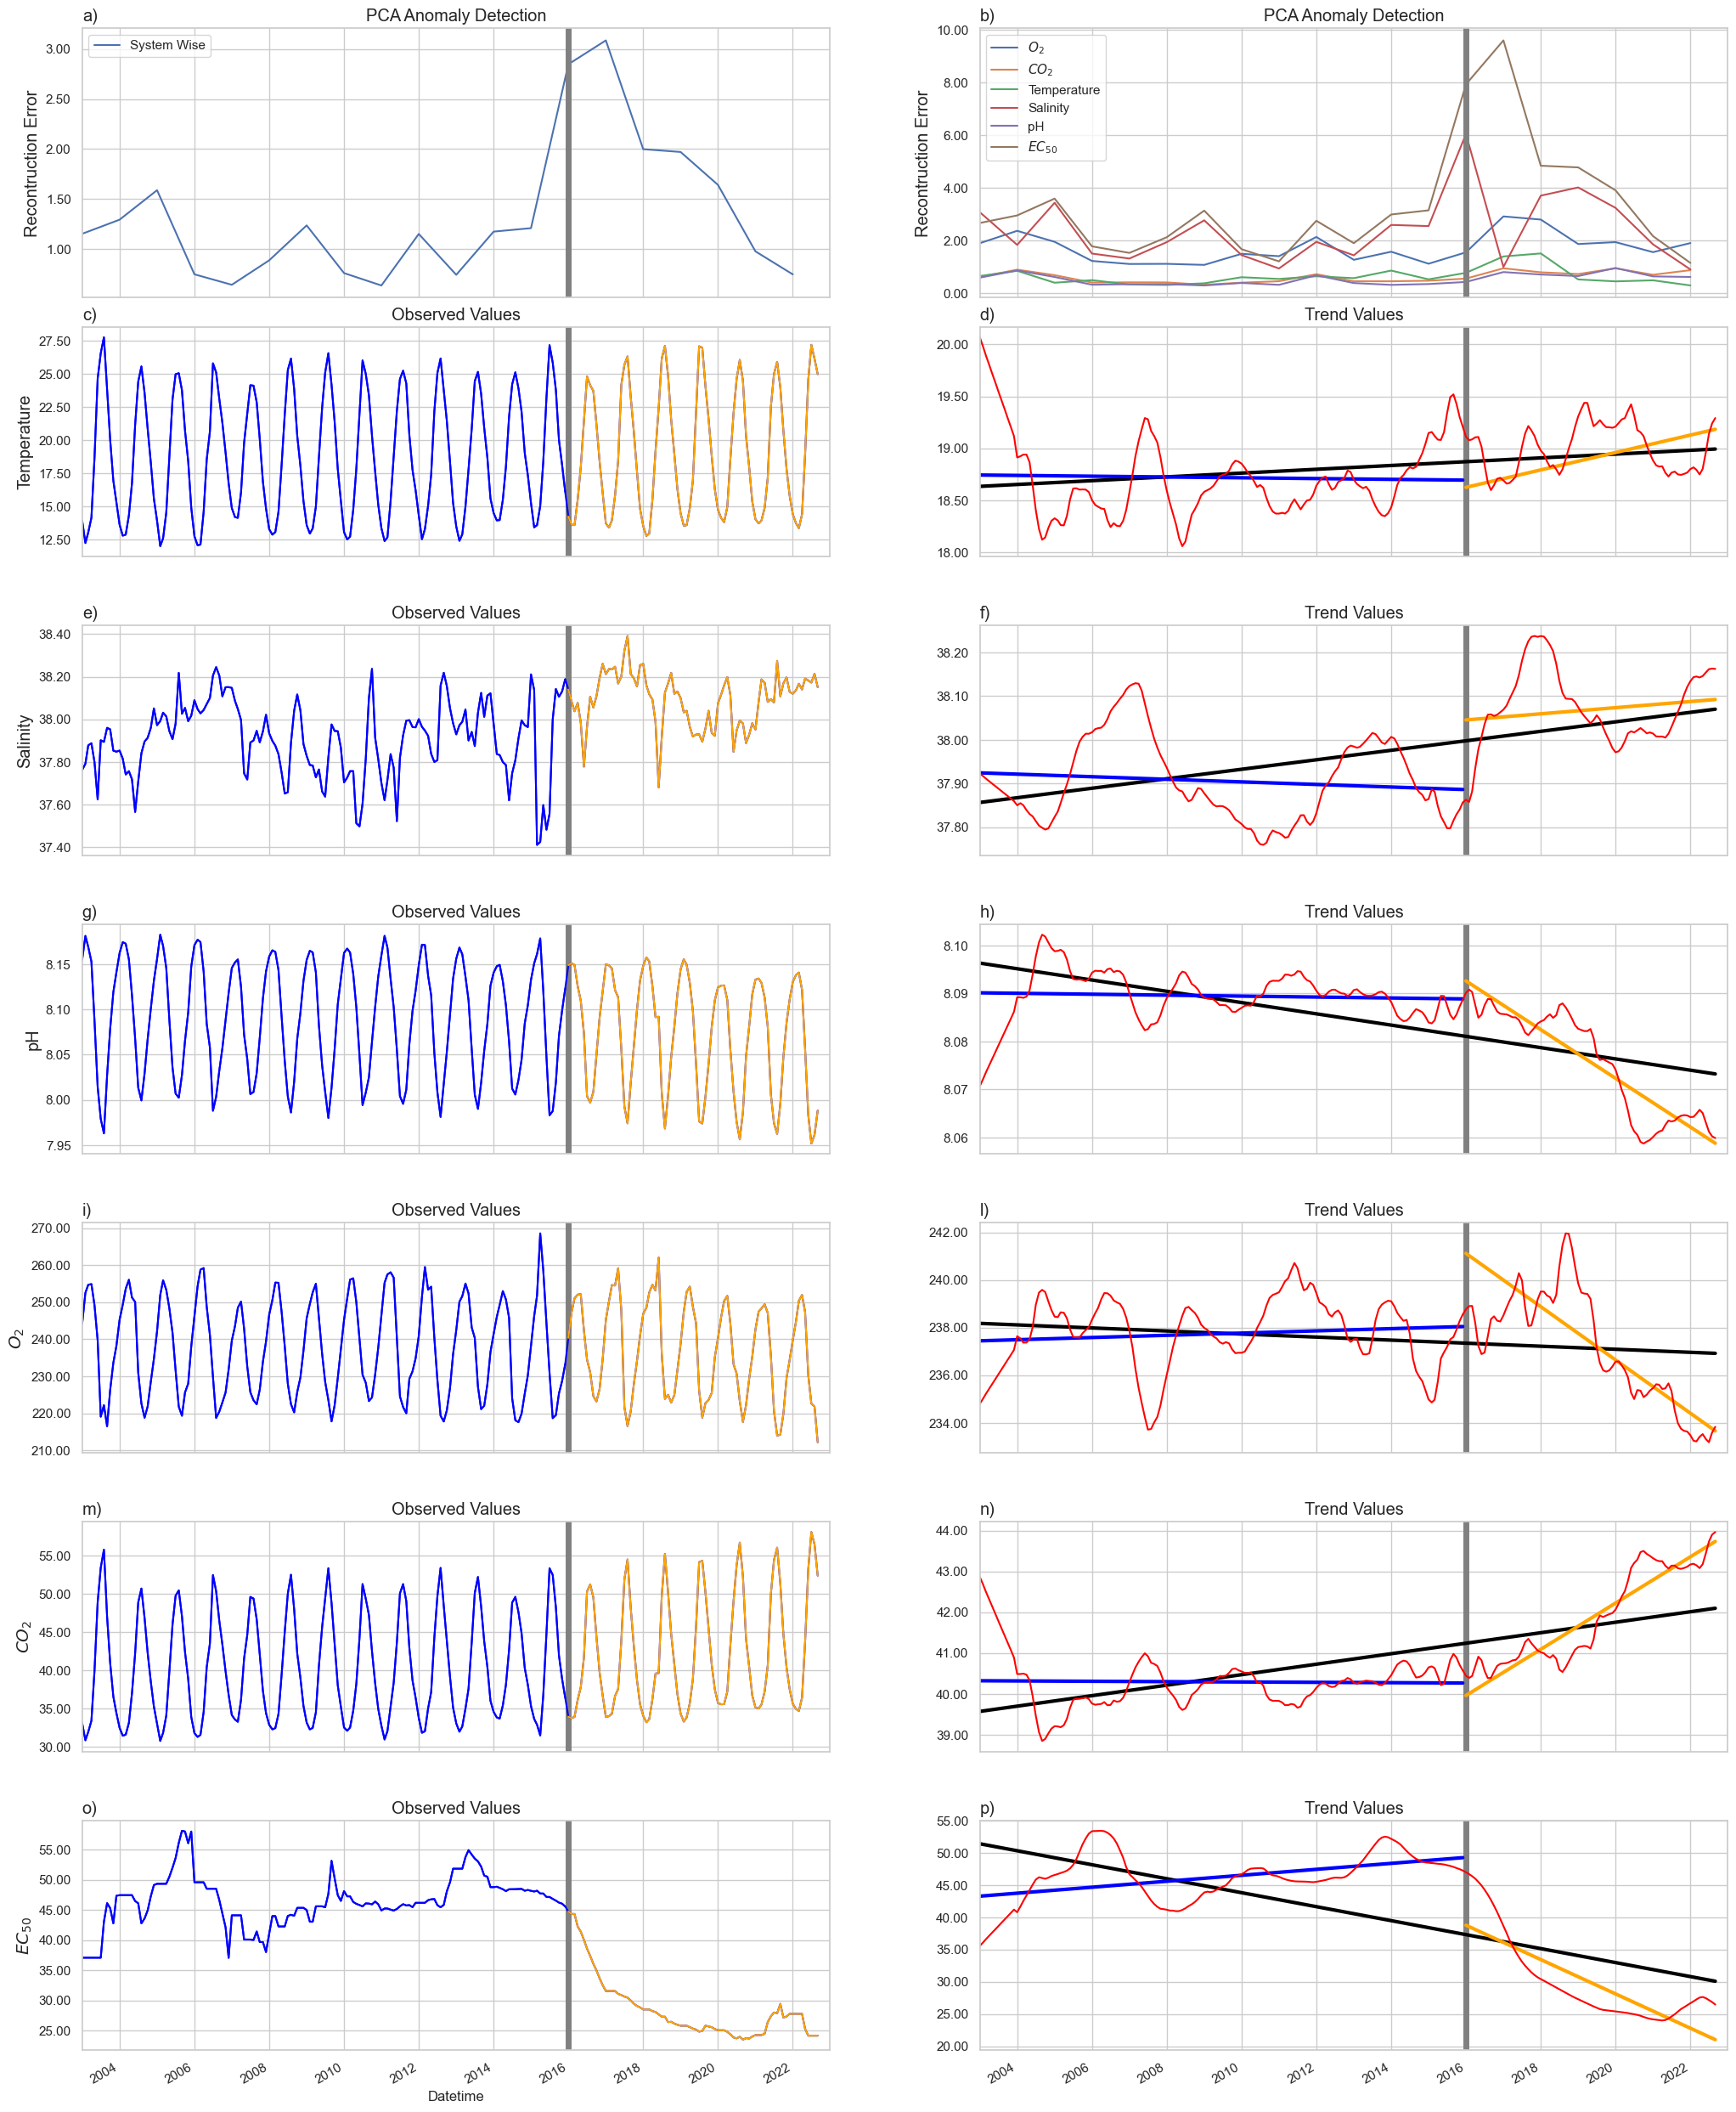

In [57]:
res2 = np.arange(np.datetime64("2003-01-01"), np.datetime64("2022-12-01"),  np.timedelta64(1, 'Y'),  dtype='datetime64[M]')
res3 = np.arange(np.datetime64("2003-01-01"), np.datetime64("2022-12-01"),  np.timedelta64(1, 'Y'),  dtype='datetime64[Y]')

def plotseasonal(res,res_pre, res_post, x1, x2, label , slopes, titoli, etichetta=False):
    x1.set_ylabel(label , size='large')
    x1.set_title("Observed Values", size='large', loc='center')
    x2.set_title("Trend Values", size='large', loc='center')
    x1.set_title(titoli[0], size='large', loc='left')
    x2.set_title(titoli[1], size='large', loc='left')
    x1.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    x2.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    temp = res.trend.to_frame().dropna().reset_index()
    xx = temp['Datetime'].copy()
    temp['Datetime']=temp['Datetime'].map(dt.datetime.toordinal)
    X = temp["Datetime"].values.reshape(-1,1)
    X = sm.add_constant(X)
    Y = temp["trend"].values.reshape(-1,1)
    reg = sm.OLS(Y, X).fit()
    y_predicted = reg.predict(X)
    slope = str(reg.params[1])
    intercept = str(round(reg.params[0],5)) 
    x1.axvline(x=np.datetime64(anno + "-01-01"), color='gray', linewidth=5)
    x2.axvline(x=np.datetime64(anno + "-01-01"), color='gray', linewidth=5)
    res.observed.plot(ax=x1,  legend=False, color='blue')
    x2.plot(xx,y_predicted, color='black',linewidth=3)
    temp = res_pre.trend.to_frame().dropna().reset_index()
    xx = temp['Datetime'].copy()
    temp['Datetime']=temp['Datetime'].map(dt.datetime.toordinal)
    X = temp["Datetime"].values.reshape(-1,1)
    X = sm.add_constant(X)
    Y = temp["trend"].values.reshape(-1,1)
    reg = sm.OLS(Y, X).fit()
    y_predicted = reg.predict(X)
    slope_pre =  str(reg.params[1])
    intercept_pre = str(round(reg.params[0],5)) 
    res_pre.observed.plot(ax=x1, sharex=x1, legend=False, color='blue')
    x2.plot(xx,y_predicted, color='blue',linewidth=3)
    temp = res_post.trend.to_frame().dropna().reset_index()
    xx = temp['Datetime'].copy()
    temp['Datetime']=temp['Datetime'].map(dt.datetime.toordinal)
    X = temp["Datetime"].values.reshape(-1,1)
    X = sm.add_constant(X)
    Y = temp["trend"].values.reshape(-1,1)
    reg = sm.OLS(Y, X).fit()
    y_predicted = reg.predict(X)
    slope_post = str(reg.params[1])
    intercept_post = str(round(reg.params[0],5)) 
    res_post.observed.plot(ax=x1, legend=False, color='orange')
    x2.plot(xx,y_predicted, color='orange',linewidth=3) 
    slopes = label + "2003-2022 S:" +  slope + " I:" + "    <" + anno +" S:" +  slope_pre + "  - I:" + "   >=" + anno +" S:" +  slope_post 
    print(slopes)
    res.trend.plot(ax=x2, legend=False, color='red')
    x2.axis(xmin=np.datetime64("2003-01-01"), xmax = np.datetime64("2023-01-01"))
    if etichetta:
        x2.set_xlabel("") 
    else :
        x1.set_xlabel("")
        x2.set_xlabel("")   

fig, axes = plt.subplots(ncols=2, nrows=7, sharex=True, sharey=False, figsize=(25,35))
plt.subplots_adjust(hspace = 0.3)
slopes = ""
cols = ["$O_{2}$","$CO_{2}$", "Temperature","Salinity", "pH", "$EC_{50}$"]
rows = ["Measures","Trend","Seasonality"]
n_features = len(cols)
for ax, col in zip(axes[0], cols):
    ax.set_title(col)
rec =   [np.mean(r) for r in rec_errors_samples.values()]
ff = plt.subplot(6,2,1)
plt.plot(res2,rec,label="System Wise")
ff.set_title("PCA Anomaly Detection", size='large', loc='center')
ff.set_title("a)", size='large', loc='left')
plt.ylabel('Recontruction Error', size='large'); 
plt.legend(loc="upper left")
ff.set_xlabel("")
ff.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ff.axvline(x=np.datetime64("2016-01-01"), color='gray', linewidth=5)
plt.xlim(np.datetime64("2003-01-01"), np.datetime64("2023-01-01"))
ff = plt.subplot(6,2,2)
for i in range(n_features):
    rec = []
    for r in rec_errors_features.values():
        rec.append(r[i])
    plt.plot(res2,rec,label=cols[i])
plt.ylabel('Recontruction Error', size='large');
ff.set_title("PCA Anomaly Detection", size='large', loc='center')
ff.set_title("b)", size='large', loc='left')
ff.set_xlabel("")
ff.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ff.axvline(x=np.datetime64(anno + "-01-01"), color='gray', linewidth=5)
plt.legend(loc="upper left")
plt.xlim(np.datetime64("2003-01-01"), np.datetime64("2023-01-01"))

plotseasonal(temperature, temperature_pre, temperature_post, axes[1,0], axes[1,1], "Temperature",slopes, titoli=["c)","d)"], etichetta=False )
plotseasonal(salinity, salinity_pre, salinity_post, axes[2,0], axes[2,1],"Salinity",slopes, titoli=["e)","f)"], etichetta=False, )
plotseasonal(ph, ph_pre, ph_post, axes[3,0], axes[3,1],"pH",slopes, titoli=["g)","h)"], etichetta=False)
plotseasonal(o2, o2_pre, o2_post, axes[4,0], axes[4,1],"$O_{2}$",slopes, titoli=["i)","l)"], etichetta=False)
plotseasonal(co2, co2_pre, co2_post, axes[5,0], axes[5,1], "$CO_{2}$",slopes, titoli=["m)","n)"], etichetta=False)
plotseasonal(ec50, ec50_pre, ec50_post, axes[6,0], axes[6,1], "$EC_{50}$",slopes, titoli=["o)","p)"], etichetta=True)

plt.show()
fig.savefig("plots-" + anno + ".pdf")

### Period split

We can perform Kruskal-Wallis and Mann-Whitneyu for EC50 values between and after 01-01-2016.

In [39]:
stats.kruskal(df_pre["EC50"],df_post["EC50"] )

KruskalResult(statistic=150.7374237488993, pvalue=1.1961316983628424e-34)

In [40]:
stats.mannwhitneyu(df_pre["EC50"],df_post["EC50"])

MannwhitneyuResult(statistic=12464.0, pvalue=1.2109868782577416e-34)

As pvalue is much greater than 0.05 we can refuse the null iphothesis that the medians of the two different periods are equal.

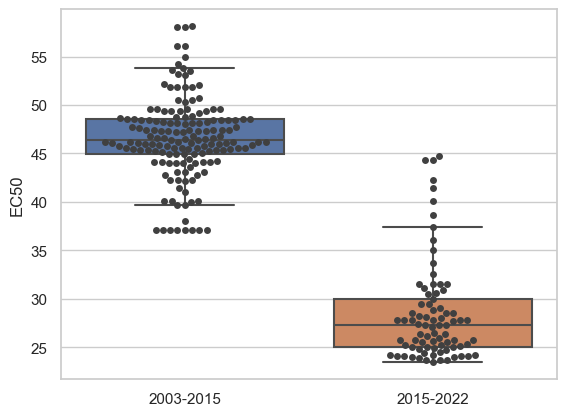

In [56]:
sns.set(style="whitegrid")
df["2016-2022"] = (df['Datetime'] >= anno + "-01-01")
fig = plt.figure()
ax = sns.boxplot(x="2016-2022", y="EC50", data=df, showfliers = False)
ax = sns.swarmplot(x="2016-2022", y="EC50", data=df, color=".25")
plt.xticks([0, 1], ['2003-2015', '2015-2022'])
ax.set_xlabel('')

plt.show()

### Correlation analysis

Test for if trends are normal distributed.

In [42]:
print("EC50 - " + str(shapiro(trend_ec50)))
print("O2 - " + str(shapiro(trend_o2)))
print("CO2 - " + str(shapiro(trend_co2)))
print("Temperature - " + str(shapiro(trend_temperature)))
print("Salinity - " + str(shapiro(trend_salinity)))
print("pH - " + str(shapiro(trend_pH)))

EC50 - ShapiroResult(statistic=0.8668988943099976, pvalue=1.6791276214508238e-13)
O2 - ShapiroResult(statistic=0.9687227010726929, pvalue=4.4526823330670595e-05)
CO2 - ShapiroResult(statistic=0.875939667224884, pvalue=5.556552397020798e-13)
Temperature - ShapiroResult(statistic=0.9771444201469421, pvalue=0.0007096421322785318)
Salinity - ShapiroResult(statistic=0.9620153307914734, pvalue=6.227187896001851e-06)
pH - ShapiroResult(statistic=0.8612942695617676, pvalue=8.223283843146814e-14)


They are not normal distributed. We have to use Spearman's algorithm to estimate the correlations between them.

In [43]:
trend_df = data[["O2", "CO2", "Temperature", "Salinity", "pH", "EC50"]].dropna()
trend_df["EC50"] = trend_ec50.to_frame().dropna().values
trend_df["O2"] = trend_o2.to_frame().dropna().values
trend_df["CO2"] = trend_co2.to_frame().dropna().values
trend_df["Temperature"] = trend_temperature.to_frame().dropna().values
trend_df["Salinity"] = trend_salinity.to_frame().dropna().values
trend_df["pH"] = trend_pH.to_frame().dropna().values

In [44]:
def my_heat(corr, ax1) :
    axes = sns.heatmap(  corr, vmin=-1, 
                            #mask=mask,
                            vmax=1, 
                            #annot=annot,
                            linewidths=2, linecolor='black',
                            square=True, #linewidths=.5,
                            cbar_kws={"shrink": .5},
                            annot=True, 
                            annot_kws={ "size": 12, 
                                        #"color":"black", 
                                        "weight":"bold"},
                            #shapesize=pval,
                            cmap='bwr',
                            rasterized=True,
                            ax=ax1)

def display_correlation(df, label):
    corr = df.corr(method="spearman")
    pval = df.corr(method=lambda x, y: spearmanr(x, y)[1]) - np.eye(*corr.shape) 
    mask = np.triu(np.ones_like(corr, dtype=bool),  k=0)
    mask |= pval >= 0.05
    corr = corr[~mask]  # fill in NaN in the non-desired cells
    remove_empty_rows_and_cols = False
    if remove_empty_rows_and_cols:
        wanted_cols = np.flatnonzero(np.count_nonzero(~mask, axis=1))
        wanted_rows = np.flatnonzero(np.count_nonzero(~mask, axis=0))
        corr = corr.iloc[wanted_cols, wanted_rows]
    fig, ax = plt.subplots()
    heatmap = my_heat(corr,ax)
    plt.close()
    return(corr,pval)

def display_corr_pairs(df,label,color="cyan"):
    from decimal import Decimal
    s = set_title = np.vectorize(lambda ax,r,rho: ax.title.set_text("r = " + 
                                        "{:.2f}".format(r) + 
                                        '\n $\\rho$ = ' + 
                                        #"{:.2f}".format(rho)
                                        '%.2E' % Decimal(rho)
                                        
                                        )
                                        if ax!=None else None
                            )      

    r,pval= display_correlation(df,label)
    return(r)

heat_map_all = display_corr_pairs(trend_df, "ALL DATA")
heat_map_post = display_corr_pairs(trend_df_post, "POST " + anno)
heat_map_pre = display_corr_pairs(trend_df_pre, "PRE " + anno)

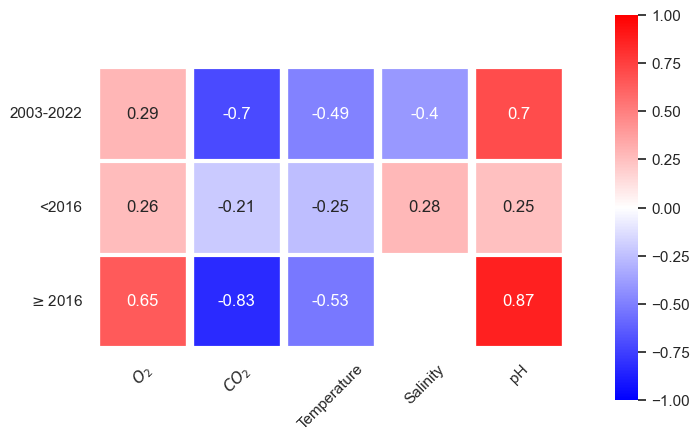

In [45]:
cols = ["$O_{2}$","$CO_{2}$", "Temperature","Salinity", "pH",  "$EC_{50}$"]
ycol= ["$EC_{50}$ Correlation"]
f,(ax1, axcb) = plt.subplots(1,2, 
            gridspec_kw={'width_ratios':[1,0.05]},
             figsize=(7,5))
temp =heat_map_all.loc['EC50',:]
#display(temp) 
temp_pre =heat_map_pre.loc['EC50',:]
temp_post =heat_map_post.loc['EC50',:]
ycol_all= ["2003-2022","<" + anno,"$\geq$" + anno ]
temp2 = np.vstack((temp,temp_pre,temp_post))
g3 = sns.heatmap( temp2, vmin=-1, 
                            #mask=mask,
                            vmax=1, 
                            #annot=annot,
                            xticklabels=cols, yticklabels=ycol_all,
                            linewidths=2, linecolor='black',
                            square=True, 
                            annot=True, 
                            cmap='bwr',
                            rasterized=True,
                            ax=ax1,
                            cbar_ax=axcb)
for i in range(temp2.shape[0] + 1):
    g3.axhline(i, color='white', lw=3)
for i in range(temp2.shape[1] + 1):
    g3.axvline(i, color='white', lw=6)
for ax in [g3]:
    tl = ax.get_xticklabels()
    ax.set_xticklabels(tl, rotation=45)
    tly = ax.get_yticklabels()
    ax.set_yticklabels(tly, rotation=0)
    ax.set_xlim(0,5)
plt.show()
f.savefig("heatmaps-" + anno + ".pdf")



heat_map_all = display_corr_pairs(trend_df, "ALL DATA")

### Causality analysis

#### Stationarity

To indagate causality we should work with stationary time series, so we test data.

In [ ]:
from statsmodels.tsa.stattools import adfuller, kpss
import pmdarima as pmd
# Stationarity
ALPHA = 0.05                
# We apply the ADF and KPSS tests of statsmodels.stattools:
# statsmodels - ADF test
# null hypothesis: There is a unit root and the series is NOT stationary 
# Low p-values are preferable
# get results as a dictionary
def ADF_statt(x):
     adf_test = adfuller(x, autolag="aic")
     t_stat, p_value, _, _, _, _  = adf_test
     conclusion = "non-stationary (unit root)" if p_value > ALPHA else "stationary"
     res_dict = {"ADF statistic":t_stat, "p-value":p_value, "should we difference?": (p_value > ALPHA), "conclusion": conclusion}
     return res_dict

# statsmodels - KPSS test
# more detailed output than pmdarima
# null hypothesis: There series is (at least trend-)stationary 
# High p-values are preferable
# get results as a dictionary
def KPSS_statt(x):
     kpss_test = kpss(x)
     t_stat, p_value, _, critical_values  = kpss_test
     conclusion = "stationary" if p_value > ALPHA else "not stationary"
     res_dict = {"KPSS statistic":t_stat, "p-value":p_value, "should we difference?": (p_value < ALPHA), "conclusion": conclusion}
     return res_dict

def test_stationary(data, variable) :
    # call the KPSS test:
    resKPSS = KPSS_statt(data[variable])
    print("---------" + variable + "----------------")
    # print dictionary of test results:
    print("KPSS test result for " + variable + " original data:")
    for key,value in (resKPSS.items()) :
        if key == "conclusion": print(key, ":", value) 

import warnings
warnings.simplefilter("ignore")

# pmdarima also offers methods that suggest the order of first differencing, based on either ADF or the KPSS test
test_stationary(df, "EC50")
test_stationary(df, "Temperature")
test_stationary(df, "pH")
test_stationary(df, "Salinity")
test_stationary(df, "CO2")
test_stationary(df, "O2")

We need to differenciate EC50 and Salinity.

In [ ]:
df["EC50_diff"] = df["EC50"].diff().dropna()
df["Salinity_diff"] = df["Salinity"].diff().dropna()

df_pre["EC50_diff"] = df_pre["EC50"].diff().dropna()
df_pre["Salinity_diff"] = df_pre["Salinity"].diff().dropna()
df_post["EC50_diff"] = df_post["EC50"].diff().dropna()
df_post["Salinity_diff"] = df_post["Salinity"].diff().dropna()

We test them again.

In [ ]:
test_stationary(df, "EC50_diff")
test_stationary(df, "Salinity_diff")

#### 

### Forecast